

Omar Pablo Jazouli Martínez



In [1]:
cd '/Users/omarjazoulimartinez/Desktop/Virtual_Internship/Week_2'

/Users/omarjazoulimartinez/Desktop/Virtual_Internship/Week_2


# G2M insight for Cab Investment firm

THE CLIENT

XYZ is a private firm in US. Due to remarkable growth in the Cab Industry in last few years and multiple key players in the market, it is planning for an investment in Cab industry and as per their Go-to-Market(G2M) strategy they want to understand the market before taking final decision.

PROJECT GOAL:

Using actionable insights to help them identify the right company to make their investment.


# Hypothesis

1-One company has generated much more profit and provided many more rides than the other one.

2-A large amount of customers of at least one company is prone to take more than 50 rides per year.

3-There is some seasonality in number of customers using the cab service.

4-There is a company that performs better in the majority of cities.

5-Profit forecast for both companies are encouraging.

In [2]:
import pandas as pd
import seaborn as sns
import re
import calendar
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime,timedelta,date
import numpy as np
%matplotlib inline
from geopy.geocoders import Nominatim
import folium
import gpxpy.geo
import json
from folium.plugins import MarkerCluster
plt.rcParams['figure.figsize'] = (6, 6)
plt.style.use('fivethirtyeight')
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.arima.model import ARIMA
import warnings 
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error 
from statsmodels.tools.eval_measures import rmse 
#plt.style.use('ggplot')

## Datasets

In [3]:
#Load datasets
cabs=pd.read_csv("Cab_Data.csv")
cities=pd.read_csv("City.csv")
customers=pd.read_csv("Customer_ID.csv")
trans=pd.read_csv("Transaction_ID.csv")

Let's take a look at each dataset

# Cabs

Variables and data type

In [4]:
cabs.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.635
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.854
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.632
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.602
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.776


In [5]:
cabs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 7 columns):
Transaction ID    359392 non-null int64
Date of Travel    359392 non-null int64
Company           359392 non-null object
City              359392 non-null object
KM Travelled      359392 non-null float64
Price Charged     359392 non-null float64
Cost of Trip      359392 non-null float64
dtypes: float64(3), int64(2), object(2)
memory usage: 19.2+ MB


Checking NAs and duplicated rows

In [54]:
cabs.isna().sum()

Transaction ID    0
Date of Travel    0
Company           0
City              0
KM Travelled      0
Price Charged     0
Cost of Trip      0
Profit            0
dtype: int64

In [55]:
cabs.duplicated().sum()

0

One can notice that the format of "Date of Travel" is quite strange. We guess that it stands for the days passed since a determined date. We need to convert it into a better known format such as DD/MM/YYYY.

In [19]:
cabs.describe()

,Transaction ID,Date of Travel,KM Travelled,Price Charged,Cost of Trip
count,3.593920e+05,359392.000000,359392.000000,359392.000000,359392.000000
mean,1.022076e+07,42964.067998,22.567254,423.443311,286.190113
std,1.268058e+05,307.467197,12.233526,274.378911,157.993661
min,1.000001e+07,42371.000000,1.900000,15.600000,19.000000
25%,1.011081e+07,42697.000000,12.000000,206.437500,151.200000
50%,1.022104e+07,42988.000000,22.440000,386.360000,282.480000
75%,1.033094e+07,43232.000000,32.960000,583.660000,413.683200
max,1.044011e+07,43465.000000,48.000000,2048.030000,691.200000


In [4]:
all_dates=set(sorted(list(cabs["Date of Travel"]),reverse=False))# all dates in cabs dataset
len(all_dates)


1095

In [4]:
d0 = date(2001, 1,1)
d1 = date(2001, 12, 31)
delta = d1 - d0
print(delta.days)# Need to add one day when counting days between two dates.

364


As there are 1095 days, we guess the date range is from 1/1/2016 to 30/12/2018:

In [11]:
d0 = date(2016, 1,1)
d1 = date(2018, 12, 30)
delta = d1 - d0
print(delta.days+1)#(366+365+364=1095)

1095


So we have  42371:= 1/1/2016,  43465:= 30/12/2018

In [10]:
d0 = date(1899, 12,30)
d1 = date(2016, 1, 1)
delta = d1 - d0
print(delta.days+1)

42371


In [9]:
d0 = date(1899, 12,30) 
d1 = date(2018, 12, 30)
delta = d1 - d0
print(delta.days+1)

43465


In [12]:
n = 42371
print((datetime(1899,12,30)+ timedelta(n-1)).strftime("%d-%m-%Y"))

01-01-2016


In [14]:
n = 43465
print((datetime(1899,12,30)+ timedelta(n-1)).strftime("%d-%m-%Y"))

30-12-2018


In [6]:
def to_date_format(n):# Transform number to date format
    date_str=(datetime(1899,12,30)+ timedelta(n-1)).strftime("%d-%m-%Y")
    date_date=datetime.strptime(date_str,'%d-%m-%Y')# string to date format
    return date_date

In [7]:
cabs["Date of Travel"]=cabs["Date of Travel"].apply(lambda x:to_date_format(x))

In [8]:
cabs=cabs.sort_values(by=['Date of Travel']) # sort dataset by date
cabs=cabs.reset_index()
cabs=cabs.drop(["index"],axis=1)
cabs.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10001340,2016-01-01,Yellow Cab,WASHINGTON DC,10.20,202.54,135.8640
1,10000640,2016-01-01,Yellow Cab,CHICAGO IL,15.60,374.66,209.6640
2,10000635,2016-01-01,Yellow Cab,CHICAGO IL,25.08,532.83,337.0752
3,10001001,2016-01-01,Yellow Cab,NEW YORK NY,46.80,1391.91,595.2960
4,10000171,2016-01-01,Pink Cab,SAN DIEGO CA,14.28,269.15,147.0840


Provided the charged price and the cost of each trip, it could be interesting to add a "Profit" column.

In [9]:
cabs["Profit"]=cabs["Price Charged"]-cabs["Cost of Trip"]

In [8]:
cabs.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Profit
0,10001340,2016-01-01,Yellow Cab,WASHINGTON DC,10.20,202.54,135.8640,66.6760
1,10000640,2016-01-01,Yellow Cab,CHICAGO IL,15.60,374.66,209.6640,164.9960
2,10000635,2016-01-01,Yellow Cab,CHICAGO IL,25.08,532.83,337.0752,195.7548
3,10001001,2016-01-01,Yellow Cab,NEW YORK NY,46.80,1391.91,595.2960,796.6140
4,10000171,2016-01-01,Pink Cab,SAN DIEGO CA,14.28,269.15,147.0840,122.0660


In [6]:
#Cabs compnies
cabs.Company.unique()

array(['Pink Cab', 'Yellow Cab'], dtype=object)

In [7]:
#Cities
cabs.City.unique()

array(['ATLANTA GA', 'AUSTIN TX', 'BOSTON MA', 'CHICAGO IL', 'DALLAS TX',
       'DENVER CO', 'LOS ANGELES CA', 'MIAMI FL', 'NASHVILLE TN',
       'NEW YORK NY', 'ORANGE COUNTY', 'PHOENIX AZ', 'PITTSBURGH PA',
       'SACRAMENTO CA', 'SAN DIEGO CA', 'SEATTLE WA', 'SILICON VALLEY',
       'TUCSON AZ', 'WASHINGTON DC'], dtype=object)

Range of numerical variables

In [9]:
cabs.describe()

,Transaction ID,KM Travelled,Price Charged,Cost of Trip,Profit
count,3.593920e+05,359392.000000,359392.000000,359392.000000,359392.000000
mean,1.022076e+07,22.567254,423.443311,286.190113,137.253198
std,1.268058e+05,12.233526,274.378911,157.993661,160.311840
min,1.000001e+07,1.900000,15.600000,19.000000,-220.060000
25%,1.011081e+07,12.000000,206.437500,151.200000,28.012000
50%,1.022104e+07,22.440000,386.360000,282.480000,81.962000
75%,1.033094e+07,32.960000,583.660000,413.683200,190.030000
max,1.044011e+07,48.000000,2048.030000,691.200000,1463.966000


# Cities

Variables. Checking NAs,duplicated rows and data type

In [8]:
cities.head()

,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"


In [18]:
cities.isna().sum()

City          0
Population    0
Users         0
dtype: int64

In [19]:
cities.duplicated().sum()

0

In [56]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
City          20 non-null object
Population    20 non-null object
Users         20 non-null object
dtypes: object(3)
memory usage: 608.0+ bytes


Population and Users are numerical variables rather than strings. Cleaning it up is needed.

In [5]:
cities["Users"][0]

' 302,149 '

In [11]:
cities["Population"][0]

' 8,405,837 '

In [6]:
def delete_white_spaces_comma(x):# function to delete white spaces and commas and change type to integer
    y=re.sub(" ","",x)
    return int(re.sub(",","",y))

In [7]:
for col in ["Users","Population"]:
    cities[col]=cities[col].apply(lambda x:delete_white_spaces_comma(x))

In [8]:
print(cities["Population"][0])
print(cities["Users"][0])

8405837
302149


We can add both latitude and longitude of each city for later representation

In [9]:
cities["Lat"]=cities["City"].apply(lambda x:Nominatim(user_agent="Omar").geocode(x).latitude)
cities["Lon"]=cities["City"].apply(lambda x:Nominatim(user_agent="Omar").geocode(x).longitude)

In [10]:
cities.head()

,City,Population,Users,Lat,Lon
0,NEW YORK NY,8405837,302149,40.712728,-74.006015
1,CHICAGO IL,1955130,164468,41.875562,-87.624421
2,LOS ANGELES CA,1595037,144132,34.053691,-118.242766
3,MIAMI FL,1339155,17675,25.774173,-80.193620
4,SILICON VALLEY,1177609,27247,37.442996,-122.154523


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

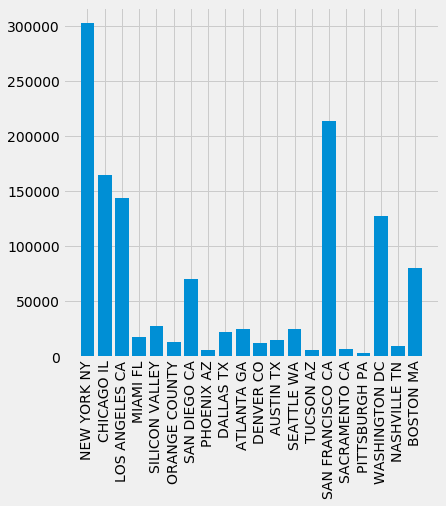

In [6]:
plt.bar(cities["City"],cities["Users"])
plt.xticks(rotation="vertical")

### Customers

Variables. Checking NAs, duplicated rows and data type

In [6]:
customers.head()

,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [22]:
customers.isna().sum()

Customer ID           0
Gender                0
Age                   0
Income (USD/Month)    0
dtype: int64

In [23]:
customers.duplicated().sum()

0

In [58]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49171 entries, 0 to 49170
Data columns (total 4 columns):
Customer ID           49171 non-null int64
Gender                49171 non-null object
Age                   49171 non-null int64
Income (USD/Month)    49171 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [65]:
customers.describe()

,Age,Income (USD/Month)
count,49171.000000,49171.000000
mean,35.363121,15015.631856
std,12.599066,8002.208253
min,18.000000,2000.000000
25%,25.000000,8289.500000
50%,33.000000,14656.000000
75%,42.000000,21035.000000
max,65.000000,35000.000000


### Transactions

Variables. Checking NAs, duplicated rows and data type

In [24]:
trans.head()

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


In [25]:
trans.isna().sum()

Transaction ID    0
Customer ID       0
Payment_Mode      0
dtype: int64

In [26]:
trans.duplicated().sum()

0

In [68]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440098 entries, 0 to 440097
Data columns (total 3 columns):
Transaction ID    440098 non-null int64
Customer ID       440098 non-null int64
Payment_Mode      440098 non-null object
dtypes: int64(2), object(1)
memory usage: 10.1+ MB


In [71]:
for col in list(trans.columns)[0:2]:
    trans[col]=trans[col].astype(str)

In [72]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440098 entries, 0 to 440097
Data columns (total 3 columns):
Transaction ID    440098 non-null object
Customer ID       440098 non-null object
Payment_Mode      440098 non-null object
dtypes: object(3)
memory usage: 10.1+ MB


# Merging datasets

All 4 datasets have a relationship and do share some information. We could gather them all into one datatest for an EDA.

Customers and transaction can be joined by the foreign key "Customer ID"

In [12]:
data1=customers.merge(right=trans, how="left",left_on=["Customer ID"], right_on=["Customer ID"])

In [14]:
data1.head()

,Customer ID,Gender,Age,Income (USD/Month),Transaction ID,Payment_Mode
0,29290,Male,28,10813,10000011,Card
1,29290,Male,28,10813,10351127,Cash
2,29290,Male,28,10813,10412921,Card
3,27703,Male,27,9237,10000012,Card
4,27703,Male,27,9237,10320494,Card


Cabs and City can be joined by the foreign key "City"

In [13]:
data2=cabs.merge(right=cities, how="left",left_on=["City"], right_on=["City"])
data2.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Profit,Population,Users
0,10001340,2016-01-01,Yellow Cab,WASHINGTON DC,10.20,202.54,135.8640,66.6760,418859,127001
1,10000640,2016-01-01,Yellow Cab,CHICAGO IL,15.60,374.66,209.6640,164.9960,1955130,164468
2,10000635,2016-01-01,Yellow Cab,CHICAGO IL,25.08,532.83,337.0752,195.7548,1955130,164468
3,10001001,2016-01-01,Yellow Cab,NEW YORK NY,46.80,1391.91,595.2960,796.6140,8405837,302149
4,10000171,2016-01-01,Pink Cab,SAN DIEGO CA,14.28,269.15,147.0840,122.0660,959307,69995


We gather the previous datsets into one by "Transaction ID"

In [14]:
data=data2.merge(right=data1, how="left",left_on=["Transaction ID"], right_on=["Transaction ID"])
data.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Profit,Population,Users,Customer ID,Gender,Age,Income (USD/Month),Payment_Mode
0,10001340,2016-01-01,Yellow Cab,WASHINGTON DC,10.20,202.54,135.8640,66.6760,418859,127001,52536,Male,24,10606,Card
1,10000640,2016-01-01,Yellow Cab,CHICAGO IL,15.60,374.66,209.6640,164.9960,1955130,164468,4844,Male,32,5548,Cash
2,10000635,2016-01-01,Yellow Cab,CHICAGO IL,25.08,532.83,337.0752,195.7548,1955130,164468,5671,Male,24,7081,Cash
3,10001001,2016-01-01,Yellow Cab,NEW YORK NY,46.80,1391.91,595.2960,796.6140,8405837,302149,2761,Male,40,11462,Card
4,10000171,2016-01-01,Pink Cab,SAN DIEGO CA,14.28,269.15,147.0840,122.0660,959307,69995,20687,Male,39,8926,Cash


We get rid of Population and Users in order to avoid having repeated information

In [15]:
data=data.drop(["Population","Users"],axis=1)
data.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Profit,Customer ID,Gender,Age,Income (USD/Month),Payment_Mode
0,10001340,2016-01-01,Yellow Cab,WASHINGTON DC,10.20,202.54,135.8640,66.6760,52536,Male,24,10606,Card
1,10000640,2016-01-01,Yellow Cab,CHICAGO IL,15.60,374.66,209.6640,164.9960,4844,Male,32,5548,Cash
2,10000635,2016-01-01,Yellow Cab,CHICAGO IL,25.08,532.83,337.0752,195.7548,5671,Male,24,7081,Cash
3,10001001,2016-01-01,Yellow Cab,NEW YORK NY,46.80,1391.91,595.2960,796.6140,2761,Male,40,11462,Card
4,10000171,2016-01-01,Pink Cab,SAN DIEGO CA,14.28,269.15,147.0840,122.0660,20687,Male,39,8926,Cash


In [53]:
data.head()

,Transaction ID,Date of Travel,Day,Month,Year,Weekday,Company,City,KM Travelled,Price Charged,Cost of Trip,Profit,Customer ID,Gender,Age,Income (USD/Month),Payment_Mode
0,10001340,2016-01-01,1,1,2016,Friday,Yellow Cab,WASHINGTON DC,10.20,202.54,135.8640,66.6760,52536,Male,24,10606,Card
1,10000640,2016-01-01,1,1,2016,Friday,Yellow Cab,CHICAGO IL,15.60,374.66,209.6640,164.9960,4844,Male,32,5548,Cash
2,10000635,2016-01-01,1,1,2016,Friday,Yellow Cab,CHICAGO IL,25.08,532.83,337.0752,195.7548,5671,Male,24,7081,Cash
3,10001001,2016-01-01,1,1,2016,Friday,Yellow Cab,NEW YORK NY,46.80,1391.91,595.2960,796.6140,2761,Male,40,11462,Card
4,10000171,2016-01-01,1,1,2016,Friday,Pink Cab,SAN DIEGO CA,14.28,269.15,147.0840,122.0660,20687,Male,39,8926,Cash


In [28]:
data.duplicated().sum()

0

In [29]:
data.isna().sum()

Transaction ID        0
Date of Travel        0
Company               0
City                  0
KM Travelled          0
Price Charged         0
Cost of Trip          0
Profit                0
Customer ID           0
Gender                0
Age                   0
Income (USD/Month)    0
Payment_Mode          0
dtype: int64

In [61]:
data["Day"]=data["Date of Travel"].apply(lambda x:x.day)
data["Month"]=data["Date of Travel"].apply(lambda x:x.month)
data["Year"]=data["Date of Travel"].apply(lambda x:x.year)
data["Weekday"]=data["Date of Travel"].apply(lambda x:calendar.day_name[x.weekday()])

In [64]:
data=data[['Transaction ID', 'Date of Travel','Day', 'Month', 'Year', 'Weekday', 'Company', 'City',
       'KM Travelled', 'Price Charged', 'Cost of Trip', 'Profit',
       'Customer ID', 'Gender', 'Age', 'Income (USD/Month)', 'Payment_Mode',
       ]]

In [66]:
data.head()

,Transaction ID,Date of Travel,Day,Month,Year,Weekday,Company,City,KM Travelled,Price Charged,Cost of Trip,Profit,Customer ID,Gender,Age,Income (USD/Month),Payment_Mode
0,10001340,2016-01-01,1,1,2016,Friday,Yellow Cab,WASHINGTON DC,10.20,202.54,135.8640,66.6760,52536,Male,24,10606,Card
1,10000640,2016-01-01,1,1,2016,Friday,Yellow Cab,CHICAGO IL,15.60,374.66,209.6640,164.9960,4844,Male,32,5548,Cash
2,10000635,2016-01-01,1,1,2016,Friday,Yellow Cab,CHICAGO IL,25.08,532.83,337.0752,195.7548,5671,Male,24,7081,Cash
3,10001001,2016-01-01,1,1,2016,Friday,Yellow Cab,NEW YORK NY,46.80,1391.91,595.2960,796.6140,2761,Male,40,11462,Card
4,10000171,2016-01-01,1,1,2016,Friday,Pink Cab,SAN DIEGO CA,14.28,269.15,147.0840,122.0660,20687,Male,39,8926,Cash


In [8]:
data["Date of Travel"]=data["Date of Travel"].apply(lambda x:datetime.strptime(x,'%Y-%m-%d'))


In [9]:
pink=data[data["Company"]=="Pink Cab"]
pink.reset_index(inplace=True)
pink=pink.drop(["index"],axis=1)                 #Pink Cab and Yellow Cab dataset

yellow=data[data["Company"]=="Yellow Cab"]
yellow.reset_index(inplace=True)
yellow=yellow.drop(["index"],axis=1)

# Profit Analysis

Which of the two companies has got more profit and provided more rides?

In [7]:
data_grouped_by=data.groupby(("Company"))["Customer ID"].agg(["count"])
incomes=data.groupby(("Company"))["Price Charged"].agg(["sum"])
expenses=data.groupby(("Company"))["Cost of Trip"].agg(["sum"])
profit=data.groupby(("Company"))["Profit"].agg(["sum"])

data_grouped_by["Incomes"]=incomes["sum"]
data_grouped_by["Expenses"]=expenses["sum"]
data_grouped_by["Profit"]=profit["sum"]

data_grouped_by.reset_index(inplace=True)
data_grouped_by.rename(columns={'count': 'Total rides'}, inplace=True)
data_grouped_by["Margin(%)"]=100*data_grouped_by["Profit"]/data_grouped_by["Incomes"]
data_grouped_by["Average profit per ride"]=data_grouped_by["Profit"]/data_grouped_by["Total rides"]
data_grouped_by

,Company,Total rides,Incomes,Expenses,Profit,Margin(%),Average profit per ride
0,Pink Cab,84711,2.632825e+07,2.102092e+07,5.307328e+06,20.158302,62.652174
1,Yellow Cab,274681,1.258539e+08,8.183351e+07,4.402037e+07,34.977365,160.259986


In [8]:
data_grouped_by=data.groupby(["Company","Year"])["Customer ID"].agg(["count"])
incomes=data.groupby(["Company","Year"])["Price Charged"].agg(["sum"])
expenses=data.groupby(["Company","Year"])["Cost of Trip"].agg(["sum"])
profit=data.groupby(["Company","Year"])["Profit"].agg(["sum"])

data_grouped_by["Incomes"]=incomes["sum"]
data_grouped_by["Expenses"]=expenses["sum"]
data_grouped_by["Profit"]=profit["sum"]

data_grouped_by.reset_index(inplace=True)
data_grouped_by.rename(columns={'count': 'Total rides'}, inplace=True)
data_grouped_by["Margin(%)"]=100*data_grouped_by["Profit"]/data_grouped_by["Incomes"]
data_grouped_by["Average profit per ride"]=data_grouped_by["Profit"]/data_grouped_by["Total rides"]

data_grouped_by["Profit Growth (%)"]=None
for i in [1,2,4,5]:
    data_grouped_by["Profit Growth (%)"][i]=100*(data_grouped_by["Profit"][i]-data_grouped_by["Profit"][i-1])/data_grouped_by["Profit"][i-1]
data_grouped_by

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Company,Year,Total rides,Incomes,Expenses,Profit,Margin(%),Average profit per ride,Profit Growth (%)
0,Pink Cab,2016,25285,7.986269e+06,6.246386e+06,1.739883e+06,21.785926,68.810861,None
1,Pink Cab,2017,30205,9.530736e+06,7.515636e+06,2.015101e+06,21.143179,66.714142,15.8182
2,Pink Cab,2018,29221,8.811246e+06,7.258901e+06,1.552345e+06,17.617770,53.124295,-22.9644
3,Yellow Cab,2016,82937,3.883363e+07,2.475974e+07,1.407389e+07,36.241491,169.693701,None
4,Yellow Cab,2017,97759,4.558291e+07,2.911865e+07,1.646427e+07,36.119383,168.416894,16.9845
5,Yellow Cab,2018,93985,4.143734e+07,2.795512e+07,1.348222e+07,32.536399,143.450759,-18.1122


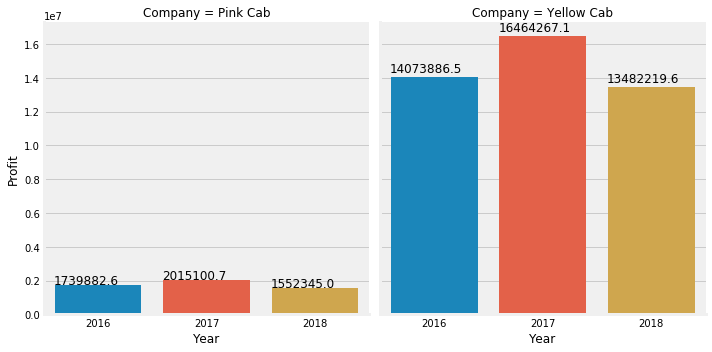

In [10]:
g=sns.catplot("Year", "Profit", col="Company", data=data_grouped_by, kind="bar")
for i in [0,1]:
    ax = g.facet_axis(0,i)
    for p in ax.patches:
        ax.text(p.get_x() - 0.01, 
                p.get_height() * 1.02, 
                '{0:.1f}'.format(p.get_height()),
                color='black', 
                rotation='horizontal', 
                size='large')

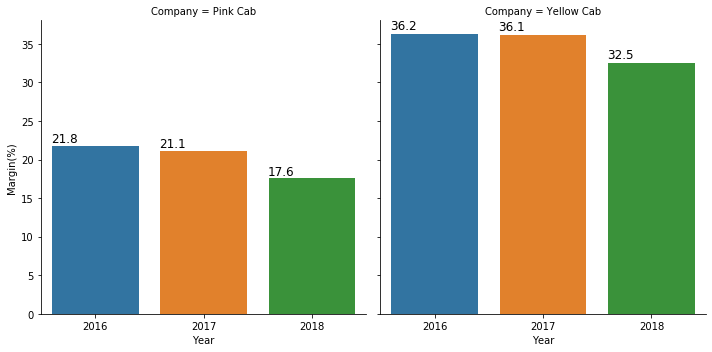

In [12]:
g=sns.catplot("Year", "Margin(%)", col="Company", data=data_grouped_by, kind="bar")
for i in [0,1]:
    ax = g.facet_axis(0,i)
    for p in ax.patches:
        ax.text(p.get_x() - 0.01, 
                p.get_height() * 1.02, 
                '{0:.1f}'.format(p.get_height()),
                color='black', 
                rotation='horizontal', 
                size='large')
    


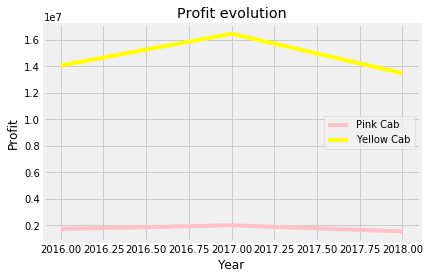

In [11]:
pink=data_grouped_by[data_grouped_by["Company"]=="Pink Cab"]
yellow=data_grouped_by[data_grouped_by["Company"]=="Yellow Cab"]
fig=plt.figure()
plt.plot([2016,2017,2018],pink["Profit"],color="pink",label="Pink Cab")
plt.plot([2016,2017,2018],yellow["Profit"],color="yellow",label="Yellow Cab")
plt.xlabel("Year")
plt.ylabel("Profit")
plt.legend()
plt.title("Profit evolution")
plt.show()

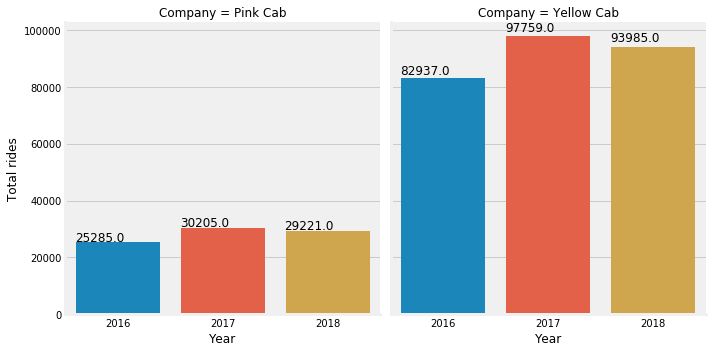

In [9]:
g=sns.catplot("Year", "Total rides", col="Company", data=data_grouped_by, kind="bar")
for i in [0,1]:
    ax = g.facet_axis(0,i)
    for p in ax.patches:
        ax.text(p.get_x() - 0.01, 
                p.get_height() * 1.02, 
                '{0:.1f}'.format(p.get_height()),
                color='black', 
                rotation='horizontal', 
                size='large')

Not only generated Yellow Cab more profit than Pink Cab did during the three years but also its margin was much better. Regarding the rides, Yellow Cab provided a larger number of them.

# Customer RETENTION

Is there a company that beat the other one in customer retention? Are the customer of these companies prone to take more than 50 rides per year?

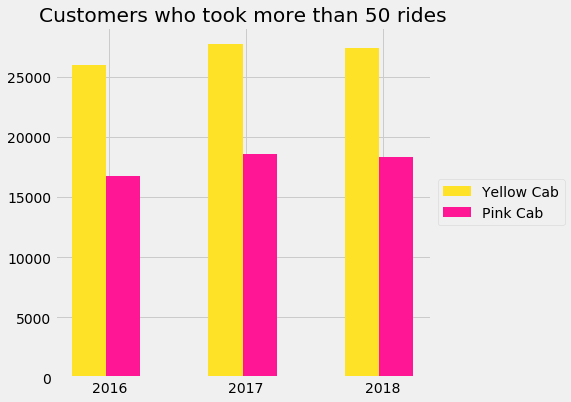

In [13]:
years=[2016,2017,2018]
customer_10_rides_yellow=[]
customer_10_rides_pink=[]
for year in years:
    yellow_year=data[(data["Year"]==year) & (data["Company"]=="Yellow Cab")].groupby("Customer ID")["Company"].agg(["count"])
    yellow_year.reset_index(inplace=True)
    yellow_year[yellow_year["count"]>=50]
    customer_10_rides_yellow.append(len(yellow_year))
    
    pink_year=data[(data["Year"]==year) & (data["Company"]=="Pink Cab")].groupby("Customer ID")["Company"].agg(["count"])
    pink_year.reset_index(inplace=True)
    pink_year[pink_year["count"]>=50]
    customer_10_rides_pink.append(len(pink_year))

X = np.arange(3)
plt.bar(X+0.00,customer_10_rides_yellow,color="#FEE227",label='Yellow Cab',width=0.25)
plt.bar(X+0.25,customer_10_rides_pink,color="#FF1694",label='Pink Cab',width=0.25)
plt.xticks(X+0.15, ["2016","2017","2018"])
leg=plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(leg.get_texts(), color='black')
plt.title("Customers who took more than 50 rides") 
plt.show()

Clearly, Yellow Cab performs better in customer retention

# Rides and profit trend

Is there any seasonality in number of customers using the cab service?

Monthly seasonality

Text(0.5, 1.0, 'Profit seasonality')

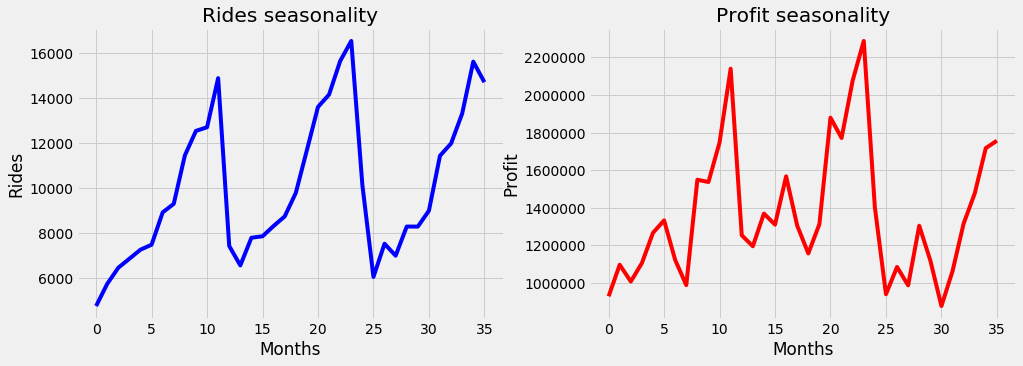

In [14]:
data_grouped_by_ym=data.groupby(["Year","Month"])["Date of Travel"].agg(["count"])
data_grouped_by_ym.reset_index(inplace=True)
data_grouped_by_ym.rename(columns={'count': 'Rides'}, inplace=True)
profits=data.groupby(["Year","Month"])["Profit"].agg(["sum"])
profits.reset_index(inplace=True)
data_grouped_by_ym["Total_profit"]=profits["sum"]

plt.rcParams['figure.figsize'] = (15, 5)
plt.subplot(121)
plt.plot(data_grouped_by_ym["Rides"],color="blue")
plt.xlabel("Months")
plt.ylabel("Rides")
plt.title("Rides seasonality")
#plt.show()
plt.subplot(122)
plt.plot(data_grouped_by_ym["Total_profit"],color="red")
plt.xlabel("Months")
plt.ylabel("Profit")
plt.title("Profit seasonality")

The general trend is pretty clear in both rides and profit evolutions. As the far as the rides trend is concerned, one can see that pick-ups rise between January and September and go down from that month onward. Regarding profit, there is a little slope from January to May and it goes up until the end of the year.

Text(0.5, 1.0, 'Profit seasonality')

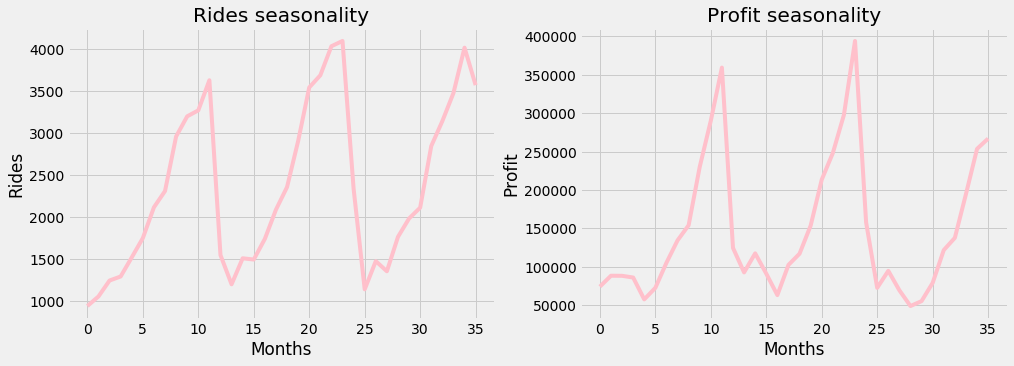

In [15]:
pink_grouped_by_ym=pink.groupby(["Year","Month"])["Date of Travel"].agg(["count"])
pink_grouped_by_ym.reset_index(inplace=True)
pink_grouped_by_ym.rename(columns={'count': 'Rides'}, inplace=True)
profits=pink.groupby(["Year","Month"])["Profit"].agg(["sum"])
profits.reset_index(inplace=True)
pink_grouped_by_ym["Total_profit"]=profits["sum"]

plt.rcParams['figure.figsize'] = (15, 5)
plt.subplot(121)
plt.plot(pink_grouped_by_ym["Rides"],color="pink")
plt.xlabel("Months")
plt.ylabel("Rides")
plt.title("Rides seasonality")
#plt.show()
plt.subplot(122)
plt.plot(pink_grouped_by_ym["Total_profit"],color="pink")
plt.xlabel("Months")
plt.ylabel("Profit")
plt.title("Profit seasonality")

Text(0.5, 1.0, 'Profit seasonality')

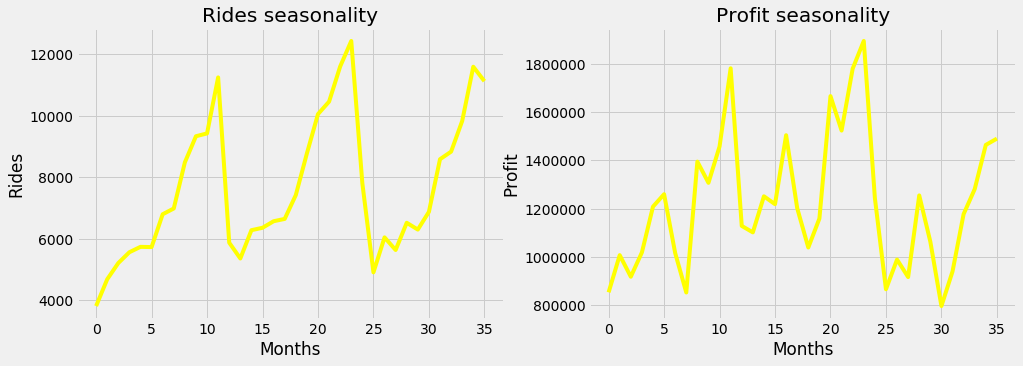

In [16]:
yellow_grouped_by_ym=yellow.groupby(["Year","Month"])["Date of Travel"].agg(["count"])
yellow_grouped_by_ym.reset_index(inplace=True)
yellow_grouped_by_ym.rename(columns={'count': 'Rides'}, inplace=True)
profits=yellow.groupby(["Year","Month"])["Profit"].agg(["sum"])
profits.reset_index(inplace=True)
yellow_grouped_by_ym["Total_profit"]=profits["sum"]

plt.rcParams['figure.figsize'] = (15, 5)
plt.subplot(121)
plt.plot(yellow_grouped_by_ym["Rides"],color="yellow")
plt.xlabel("Months")
plt.ylabel("Rides")
plt.title("Rides seasonality")
#plt.show()
plt.subplot(122)
plt.plot(yellow_grouped_by_ym["Total_profit"],color="yellow")
plt.xlabel("Months")
plt.ylabel("Profit")
plt.title("Profit seasonality")

In [ ]:
plt.plot(data_grouped_by_date["Rides"],data_grouped_by_date["Margin(%)"],"ro")
plt.ylabel("Margin")
plt.xlabel("Rides")
data_grouped_by_date.corr(method ='pearson'

Daily seasonality

In [18]:
data_grouped_by_date=data[data["Company"]=="Pink Cab"].groupby(("Date of Travel"))["Date of Travel"].agg(["count"])
data_grouped_by_date.reset_index(inplace=True)
data_grouped_by_date.rename(columns={'count': 'Rides'}, inplace=True)

profits=data[data["Company"]=="Pink Cab"].groupby(("Date of Travel"))["Profit"].agg(["sum"])
profits.reset_index(inplace=True)
incomes=data[data["Company"]=="Pink Cab"].groupby(("Date of Travel"))["Price Charged"].agg(["sum"])
incomes.reset_index(inplace=True)
data_grouped_by_date["Total_profit"]=profits["sum"]
data_grouped_by_date["Total_incomes"]=incomes["sum"]
data_grouped_by_date["Margin(%)"]=100*data_grouped_by_date["Total_profit"]/data_grouped_by_date["Total_incomes"]
data_grouped_by_date

,Date of Travel,Rides,Total_profit,Total_incomes,Margin(%)
0,2016-01-01,41,4809.421,13858.58,34.703563
1,2016-01-02,52,10620.582,25375.33,41.853966
2,2016-01-03,4,428.591,1266.07,33.852078
3,2016-01-04,6,745.359,2505.80,29.745351
4,2016-01-05,23,2336.981,7957.59,29.367949
...,...,...,...,...,...
1090,2018-12-26,66,4299.130,20457.74,21.014687
1091,2018-12-27,217,18478.900,71309.55,25.913640
1092,2018-12-28,195,19399.999,68126.84,28.476294
1093,2018-12-29,56,4019.056,17922.82,22.424239


Text(0.5, 1.0, 'Profit seasonality')

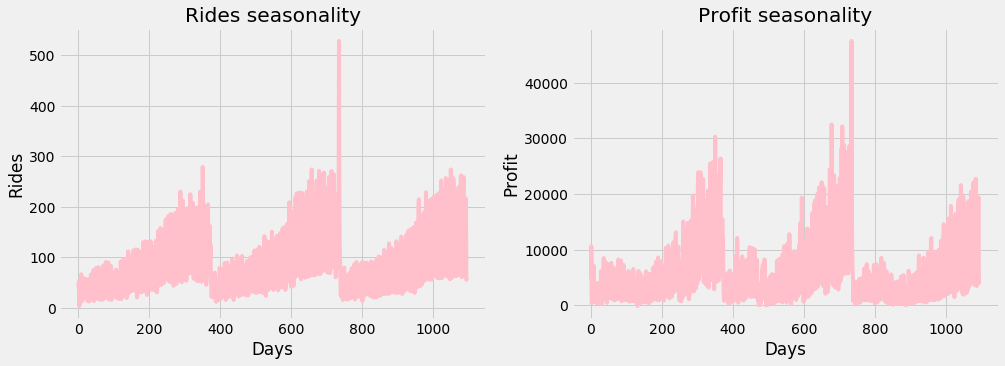

In [19]:
plt.rcParams['figure.figsize'] = (15, 5)
plt.subplot(121)
plt.plot(data_grouped_by_date["Rides"],color="pink")
plt.xlabel("Days")
plt.ylabel("Rides")
plt.title("Rides seasonality")
plt.subplot(122)
plt.plot(data_grouped_by_date["Total_profit"],color="pink")
plt.xlabel("Days")
plt.ylabel("Profit")
plt.title("Profit seasonality")

In [43]:
data_grouped_by_date[data_grouped_by_date["Rides"]>500]["Date of Travel"][734]

Timestamp('2018-01-04 00:00:00')

Normally, Pink Cab has beetween 10 and 300 rides every day. On January 4th (2018) there is an outlier. 

Text(0, 0.5, 'Profit')

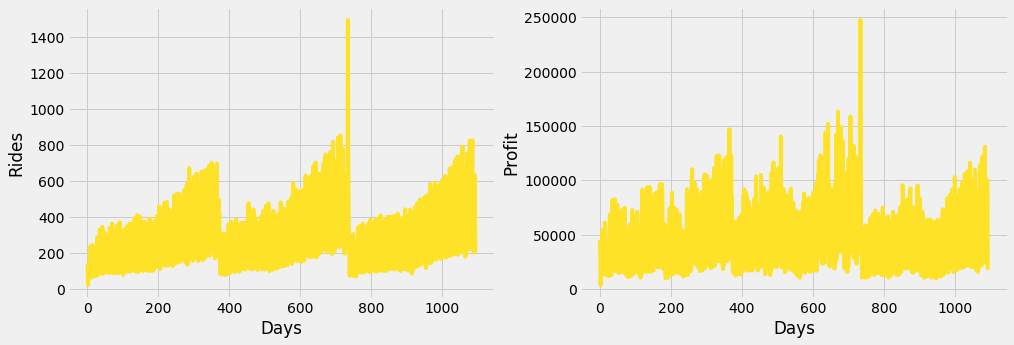

In [20]:

data_grouped_by_date=data[data["Company"]=="Yellow Cab"].groupby(("Date of Travel"))["Date of Travel"].agg(["count"])
data_grouped_by_date.reset_index(inplace=True)
data_grouped_by_date.rename(columns={'count': 'Rides'}, inplace=True)
profits=data[data["Company"]=="Yellow Cab"].groupby(("Date of Travel"))["Profit"].agg(["sum"])
profits.reset_index(inplace=True)
data_grouped_by_date["Total_profit"]=profits["sum"]
plt.rcParams['figure.figsize'] = (15, 5)

plt.subplot(121)
plt.plot(data_grouped_by_date["Rides"],color="#FEE227")
plt.xlabel("Days")
plt.ylabel("Rides")
plt.subplot(122)
plt.plot(data_grouped_by_date["Total_profit"],color="#FEE227")
plt.xlabel("Days")
plt.ylabel("Profit")

In [45]:
data_grouped_by_date[data_grouped_by_date["Rides"]>1400]

,Date of Travel,Rides,Total_profit
734,2018-01-04,1494,247506.2492


Both companys share similar trends but, Yellow Cab has,in general, more rides and profit per day. 4/1/2018 looks like a special day for taking a ride (there is a clear outlier) 

# Most important cities

Is there a company that performs better in the majority of cities? Let's see their results in terms of profit and rides

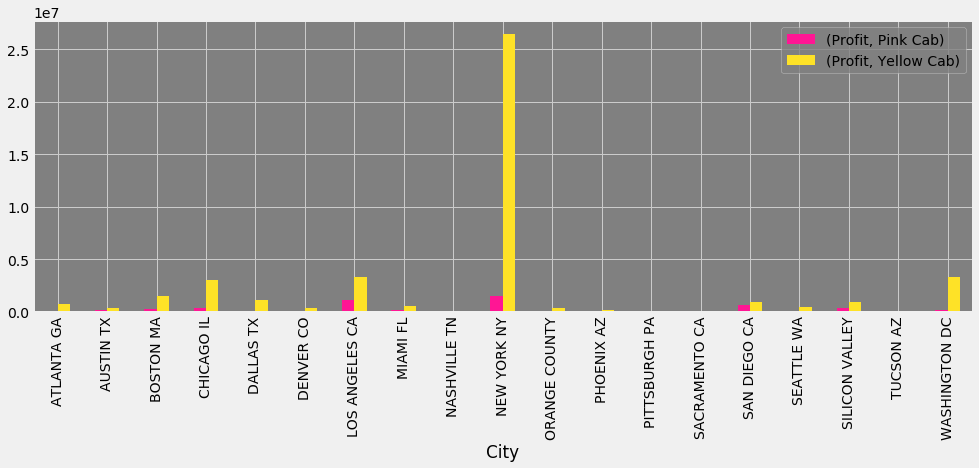

In [21]:
data_grouped_by=data.groupby(["City","Company"])["Profit"].agg(["sum"])# Both company's profit in each city
data_grouped_by_unstack=data_grouped_by.unstack()
data_grouped_by_unstack.rename(columns={'sum': 'Profit'}, inplace=True)
plt.rcParams['axes.facecolor'] = "grey"
data_grouped_by_unstack.plot.bar(color=["#FF1694","#FEE227"])
plt.legend()
plt.show()

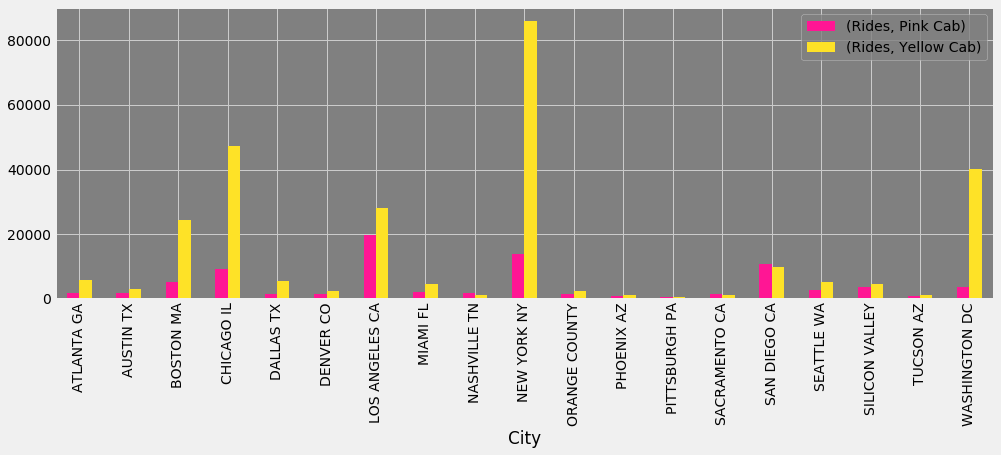

In [22]:
data_grouped_by=data.groupby(["City","Company"])["Customer ID"].agg(["count"])# Counting rides per city and company.
data_grouped_by_unstack=data_grouped_by.unstack()
data_grouped_by_unstack.rename(columns={'count': 'Rides'}, inplace=True)

plt.rcParams['axes.facecolor'] = "grey"
data_grouped_by_unstack.plot.bar(color=["#FF1694","#FEE227"])
plt.legend()
plt.show()

In [23]:
data_grouped_by.reset_index(inplace=True)
data_grouped_by.rename(columns={'count': 'Total Rides'}, inplace=True)
data_grouped_by=data_grouped_by.merge(right=cities, how="left",left_on=["City"], right_on=["City"])
data_grouped_by.head()

,City,Company,Total Rides,Population,Users,Lat,Lon
0,ATLANTA GA,Pink Cab,1762,814885,24701,33.748992,-84.390264
1,ATLANTA GA,Yellow Cab,5795,814885,24701,33.748992,-84.390264
2,AUSTIN TX,Pink Cab,1868,698371,14978,30.271129,-97.743700
3,AUSTIN TX,Yellow Cab,3028,698371,14978,30.271129,-97.743700
4,BOSTON MA,Pink Cab,5186,248968,80021,42.360253,-71.058291


In [24]:
folium_map = folium.Map(location=[48, -102], zoom_start=4,tiles="CartoDB dark_matter")# Plotting a couple of bubbles per city with radius=number of rides

pink_grouped=data_grouped_by[data_grouped_by["Company"]=="Pink Cab"]#
pink_grouped.reset_index(inplace=True)
pink_rides={}#dictionary containing the cities and the number of rides taken by Pink Cab
for city in list(pink_grouped.City.unique()):
    pink_rides[city]=int(pink_grouped[pink_grouped["City"]==city]["Total Rides"])

yellow_grouped=data_grouped_by[data_grouped_by["Company"]=="Yellow Cab"]
yellow_grouped.reset_index(inplace=True)
yellow_rides={}#dictionary containing the cities and the number of rides taken by Yellow Cab
for city in list(yellow_grouped.City.unique()):
    yellow_rides[city]=int(yellow_grouped[yellow_grouped["City"]==city]["Total Rides"])

for i in range(len(pink_grouped)):
    folium.CircleMarker(location=([pink_grouped["Lat"][i],pink_grouped["Lon"][i]]),
                        radius=0.0003*pink_rides[pink_grouped["City"][i]],#plotting pink bubbles
                        color="pink",
                        fill=True).add_to(folium_map)    
for i in range(len(yellow_grouped)):
    folium.CircleMarker(location=([yellow_grouped["Lat"][i],yellow_grouped["Lon"][i]]),
                        radius=0.0003*yellow_rides[yellow_grouped["City"][i]],#plotting yellow bubbles
                        color="yellow",
                        fill=False).add_to(folium_map)
folium_map

One can observe that indeed Yellow Cab performed far away better than Pink Cab did in almost every city. There were no rides in San Fancisco though.

#  Customer reach

Is there a company that reachs customers better than the other one? Let's see the number of customers of each company in each city (at the end of 2018)

In [27]:
len(data["Customer ID"].unique())#Total number of customers during the period

46148

In [31]:
cities.head()

,City,Population,Users,Lat,Lon
0,NEW YORK NY,8405837,302149,40.712728,-74.006015
1,CHICAGO IL,1955130,164468,41.875562,-87.624421
2,LOS ANGELES CA,1595037,144132,34.053691,-118.242766
3,MIAMI FL,1339155,17675,25.774173,-80.193620
4,SILICON VALLEY,1177609,27247,37.442996,-122.154523


In [25]:
pink_grouped_by=pink.groupby(["City","Year"])["Customer ID"].nunique().to_frame().reset_index()# Pink Cab users per city and year
yellow_grouped_by=yellow.groupby(["City","Year"])["Customer ID"].nunique().to_frame().reset_index()#Yellow Cab users per city and year


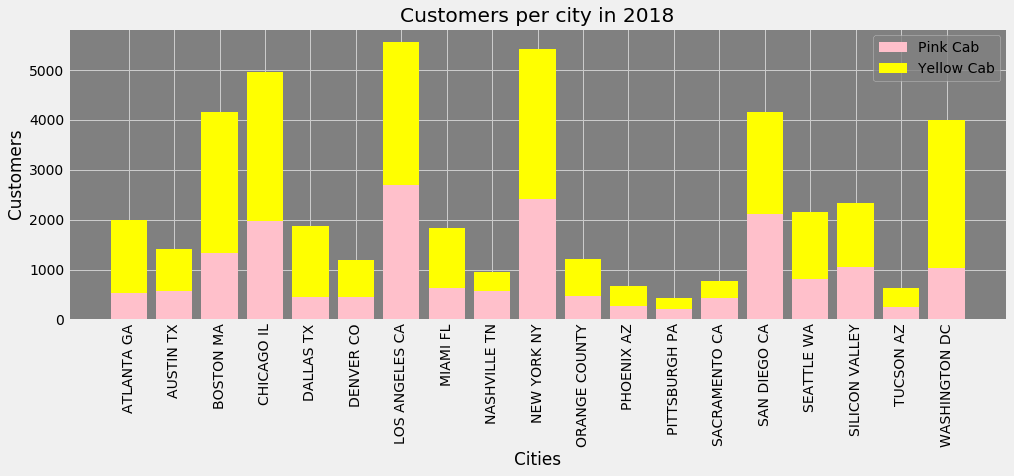

In [26]:
pink_year=pink_grouped_by[pink_grouped_by["Year"]==2018]
yellow_year=yellow_grouped_by[yellow_grouped_by["Year"]==2018]
cit = list(pink_year.City.unique())
pink_cust = list(pink_year["Customer ID"].values)
yellow_cust= list(yellow_year["Customer ID"].values)
ind = np.arange(len(cit))

plt.bar(ind, pink_cust, label='Pink Cab',color="pink")
plt.bar(ind, yellow_cust, label='Yellow Cab',  bottom=pink_cust,color="yellow")
plt.xticks(ind, cit,rotation="vertical")
plt.ylabel("Customers")
plt.xlabel("Cities")
plt.title('Customers per city in 2018')
plt.legend()
plt.show()
    

At the end of 2018, Yellow Cab has more users than Pink Cab in 13 out of 19 cities.

# Rides and Profit Forecasting for 2019

In [5]:
pd.set_option('display.max_columns', None)

We are going to build four models to predict each company's profit for year 2019

For the forecast, an ARIMA model will be used.


In [82]:
pink_grouped_by_date=data[data["Company"]=="Pink Cab"].groupby(["Year","Month"])["Transaction ID"].agg(["count"])
pink_grouped_by_date.reset_index(inplace=True)
pink_grouped_by_date.rename(columns={'count': 'Rides'}, inplace=True)

profits=data[data["Company"]=="Pink Cab"].groupby(["Year","Month"])["Profit"].agg(["mean"])
profits.reset_index(inplace=True)

pink_grouped_by_date["Avg_profit"]=profits["mean"]

def get_date(x):
    return datetime.strptime(x["Month"]+"-"+x["Year"],'%m-%Y')


pink_grouped_by_date.head()
pink_grouped_by_date["Month"]=pink_grouped_by_date["Month"].apply(lambda x:str(x))
pink_grouped_by_date["Year"]=pink_grouped_by_date["Year"].apply(lambda x:str(x))
pink_grouped_by_date["Date"]=pink_grouped_by_date.apply(lambda x:get_date(x),axis=1)
pink_grouped_by_date.set_index('Date',inplace=True)
pink_grouped_by_date.head()


,Year,Month,Rides,Avg_profit
Date,,,,
2016-01-01,2016,1,940,78.942733
2016-02-01,2016,2,1054,83.856066
2016-03-01,2016,3,1244,70.965219
2016-04-01,2016,4,1292,66.608585
2016-05-01,2016,5,1519,37.924848


In [16]:
yellow_grouped_by_date=data[data["Company"]=="Yellow Cab"].groupby(["Year","Month"])["Transaction ID"].agg(["count"])
yellow_grouped_by_date.reset_index(inplace=True)
yellow_grouped_by_date.rename(columns={'count': 'Rides'}, inplace=True)

profits=data[data["Company"]=="Yellow Cab"].groupby(["Year","Month"])["Profit"].agg(["mean"])
profits.reset_index(inplace=True)

yellow_grouped_by_date["Avg_profit"]=profits["mean"]

def get_date(x):
    return datetime.strptime(x["Month"]+"-"+x["Year"],'%m-%Y')


yellow_grouped_by_date.head()
yellow_grouped_by_date["Month"]=yellow_grouped_by_date["Month"].apply(lambda x:str(x))
yellow_grouped_by_date["Year"]=yellow_grouped_by_date["Year"].apply(lambda x:str(x))
yellow_grouped_by_date["Date"]=yellow_grouped_by_date.apply(lambda x:get_date(x),axis=1)
yellow_grouped_by_date.set_index('Date',inplace=True)
yellow_grouped_by_date.head()

,Year,Month,Rides,Avg_profit
Date,,,,
2016-01-01,2016,1,3805,224.332733
2016-02-01,2016,2,4676,215.457425
2016-03-01,2016,3,5204,176.430290
2016-04-01,2016,4,5556,183.354379
2016-05-01,2016,5,5731,210.817059


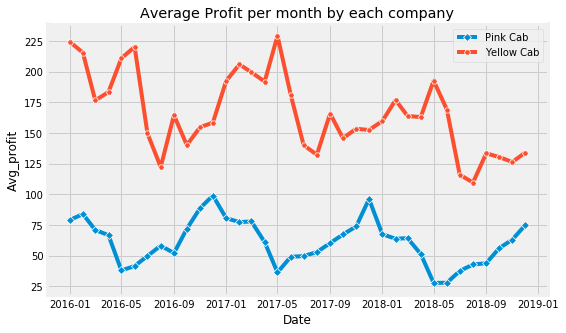

In [48]:
plt.figure(figsize = (8,5))
sns.lineplot(x="Date", y='Avg_profit', data=pink_grouped_by_date, marker='D')
sns.lineplot(x="Date", y='Avg_profit', data=yellow_grouped_by_date, marker='H')
plt.legend(['Pink Cab', 'Yellow Cab'])
plt.title('Average Profit per month by each company')
plt.xlabel('Date')

plt.show()

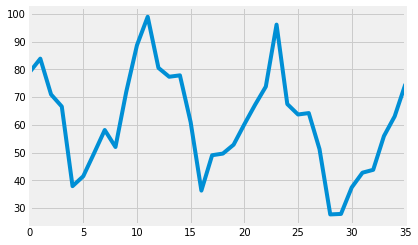

In [49]:
pink_grouped_by_date["Avg_profit"].plot()

Yellow Cab Forecasting

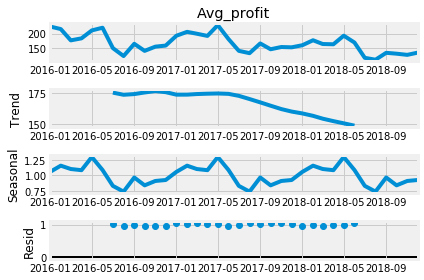

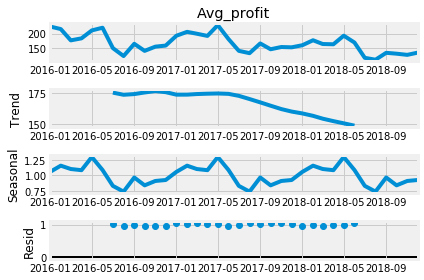

In [92]:
# ETS Decomposition 
result = seasonal_decompose(yellow_grouped_by_date['Avg_profit'],  
                            model ='multiplicative') 
  
# ETS plot  
result.plot() 

In [93]:
 #Fit auto_arima function to pink_grouped_by_date dataset 
stepwise_fit = auto_arima(yellow_grouped_by_date['Avg_profit'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=210.947, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=206.953, Time=0.11 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=220.793, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=208.369, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=208.934, Time=0.56 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=0.65 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=207.259, Time=0.06 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=208.949, Time=0.13 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=208.951, Time=0.19 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=207.294, Time=0.16 sec
 ARIMA(2,0,1)(1,1,0)[12] intercept   : AIC=210.029, T

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   36
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 -99.476
Date:                            Sat, 06 Mar 2021   AIC                            206.953
Time:                                    12:45:59   BIC                            211.665
Sample:                                         0   HQIC                           208.203
                                             - 36                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    -15.0909      5.877     -2.568      0.010     -26.610      -3.572
ar.L1          0.3344      0.213      1.573      0.116      -0.082       0.751
ar.S.L12      -0.5194      0.278     -1.870      0.061      -1.064       0.025
sigma2       198.0310     73.735      2.686      0.007      53.514     342.548
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 0.61
Prob(Q):                              0.78   Prob(JB):                         0.74
Heteroskedasticity (H):               0.16   Skew:                            -0.37
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:


# Split data into train / test sets 
train = yellow_grouped_by_date.iloc[:len(yellow_grouped_by_date)-12] #2016,2017 for training
test = yellow_grouped_by_date.iloc[len(yellow_grouped_by_date)-12:] # set 2018(12 months) for testing 
  
# Fit a SARIMAX(1, 0, 0)x(1, 1, 0, 12) on the training set 
 
model = SARIMAX(train['Avg_profit'],  
                order = (1, 0, 0),  
                seasonal_order =(1, 1, 0, 12)) 
  
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Avg_profit   No. Observations:                   24
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 -51.611
Date:                            Sat, 06 Mar 2021   AIC                            109.222
Time:                                    12:46:00   BIC                            110.677
Sample:                                01-01-2016   HQIC                           108.684
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0445      0.454     -0.098      0.922      -0.934       0.845
ar.S.L12      -0.9688     39.894     -0.024      0.981     -79.160      77.223
sigma2        19.6432   2.47e+04      0.001      0.999   -4.84e+04    4.84e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.91
Prob(Q):                              0.89   Prob(JB):                         0.63
Heteroskedasticity (H):               0.03   Skew:                            -0.64
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

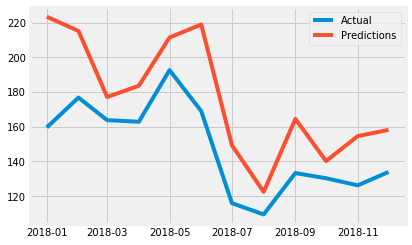

In [95]:



start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 

plt.plot(test['Avg_profit'],label="Actual")
plt.plot(predictions.to_frame()["Predictions"],label="Predictions")
plt.legend()
plt.show()


In [70]:




# Load specific evaluation tools 

  
# Calculate root mean squared error 
rmse(test["Avg_profit"], predictions) 
  
# Calculate mean squared error 
mean_squared_error(test["Avg_profit"], predictions)

1060.6322132158023

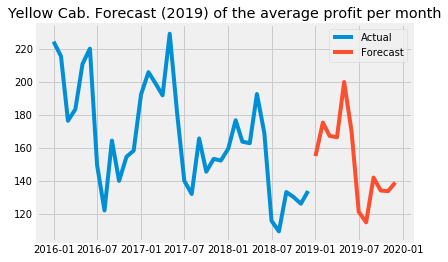

In [97]:


# Train the model on the full dataset 
model = model = SARIMAX(yellow_grouped_by_date['Avg_profit'],  
                        order = (1, 0, 0),  
                        seasonal_order =(1, 1, 0, 12)) 
result = model.fit() 
  
# Forecast for the next year
forecast_yellow = result.predict(start = len(yellow_grouped_by_date),  
                          end = (len(yellow_grouped_by_date)-1) + 1 * 12,  
                          typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 


plt.plot(yellow_grouped_by_date['Avg_profit'],label="Actual")
plt.plot(forecast_yellow.to_frame()["Forecast"],label="Forecast")
plt.legend()
plt.title("Yellow Cab. Forecast (2019) of the average profit per month")
plt.show()

Pink Cab Forecast

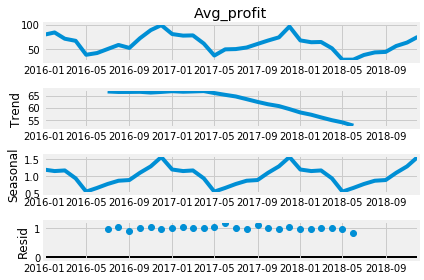

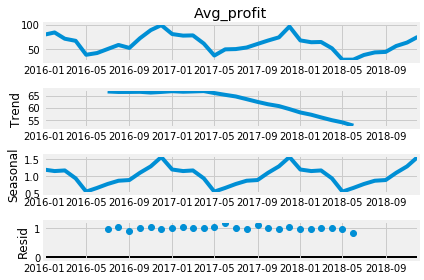

In [98]:
# ETS Decomposition 
result = seasonal_decompose(pink_grouped_by_date['Avg_profit'],  
                            model ='multiplicative') 
  
# ETS plot  
result.plot() 

In [99]:
#Fit auto_arima function to pink_grouped_by_date dataset 
stepwise_fit = auto_arima(pink_grouped_by_date['Avg_profit'], start_p = 1, start_q = 1, 
                          max_p = 3, max_q = 3, m = 12, 
                          start_P = 0, seasonal = True, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise 
  
# To print the summary 
stepwise_fit.summary() 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=166.615, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=157.230, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=162.183, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=160.993, Time=0.87 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=162.826, Time=0.03 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=151.774, Time=0.06 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=149.901, Time=0.03 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AIC=151.728, Time=0.06 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(3,1,0)(0,1,0)[12]             : AIC=151.689, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   36
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 12)   Log Likelihood                 -70.548
Date:                            Sat, 06 Mar 2021   AIC                            149.096
Time:                                    12:46:54   BIC                            153.638
Sample:                                         0   HQIC                           150.238
                                             - 36                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.8944      1.181     -1.604      0.109      -4.210       0.421
ar.L1         -0.8731      0.161     -5.419      0.000      -1.189      -0.557
ar.L2         -0.7438      0.149     -5.000      0.000      -1.035      -0.452
sigma2        24.8819     16.477      1.510      0.131      -7.412      57.176
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 2.05
Prob(Q):                              0.79   Prob(JB):                         0.36
Heteroskedasticity (H):               0.70   Skew:                            -0.23
Prob(H) (two-sided):                  0.63   Kurtosis:                         1.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [100]:
# Split data into train / test sets 
train = pink_grouped_by_date.iloc[:len(pink_grouped_by_date)-12] #2016,2017 for training
test = pink_grouped_by_date.iloc[len(pink_grouped_by_date)-12:] # set 2018(12 months) for testing 
  
# Fit a SARIMAX(2, 1, 0)x(0, 1, 0, 12) on the training set 
 
model = SARIMAX(train['Avg_profit'],  
                order = (1, 0, 0),  
                seasonal_order =(1, 1, 0, 12)) 
  
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         Avg_profit   No. Observations:                   24
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 12)   Log Likelihood                 -39.646
Date:                            Sat, 06 Mar 2021   AIC                             85.293
Time:                                    12:46:55   BIC                             86.748
Sample:                                01-01-2016   HQIC                            84.754
                                     - 12-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1352      0.524     -0.258      0.796      -1.162       0.892
ar.S.L12       0.9595     32.552      0.029      0.976     -62.841      64.760
sigma2         3.4400   2709.260      0.001      0.999   -5306.612    5313.492
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 0.23
Prob(Q):                              0.71   Prob(JB):                         0.89
Heteroskedasticity (H):               3.31   Skew:                            -0.32
Prob(H) (two-sided):                  0.27   Kurtosis:                         2.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

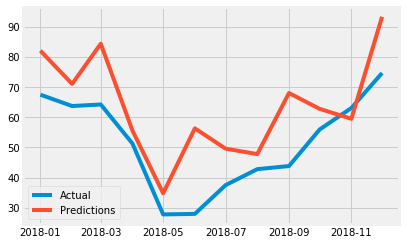

In [101]:
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 

plt.plot(test['Avg_profit'],label="Actual")
plt.plot(predictions.to_frame()["Predictions"],label="Predictions")
plt.legend()
plt.show()

In [87]:
# Load specific evaluation tools 

  
# Calculate root mean squared error 
rmse(test["Avg_profit"], predictions) 
  
# Calculate mean squared error 
mean_squared_error(test["Avg_profit"], predictions)

226.46820133076866

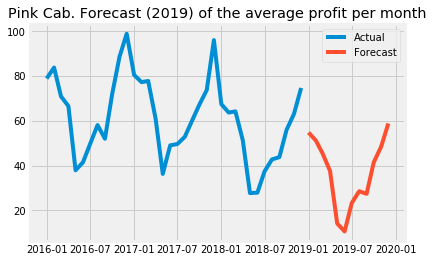

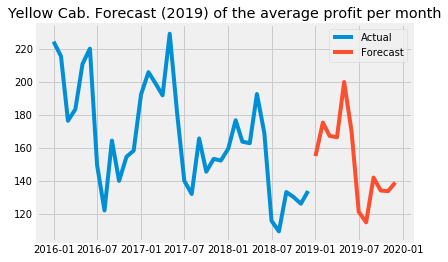

In [105]:
# Train the model on the full dataset 
model = model = SARIMAX(pink_grouped_by_date['Avg_profit'],  
                        order = (2, 1, 0),  
                        seasonal_order =(0, 1, 0, 12)) 
result = model.fit() 
  
# Forecast for the next year
forecast_pink = result.predict(start = len(pink_grouped_by_date),  
                          end = (len(pink_grouped_by_date)-1) + 1 * 12,  
                          typ = 'levels').rename('Forecast') 
  
# Plot the forecast values 


plt.plot(pink_grouped_by_date['Avg_profit'],label="Actual")
plt.plot(forecast_pink.to_frame()["Forecast"],label="Forecast")
plt.legend()
plt.title("Pink Cab. Forecast (2019) of the average profit per month")
plt.show()

# We plot again the forecast for Yellow Cab for better comparison

plt.plot(yellow_grouped_by_date['Avg_profit'],label="Actual")
plt.plot(forecast_yellow.to_frame()["Forecast"],label="Forecast")
plt.legend()
plt.title("Yellow Cab. Forecast (2019) of the average profit per month")
plt.show()

We can see that Pink Cab's monthly profit is going down untill June and rising form that moment onward.
Yellow Cab's profit experiences a huge fall from April to July.

However, the minimum of Yellow Cab's profit is greater than any value of Pink Cab's profit.
So, we can say that forecast for Yellow Cab give us more confidence.

# Recommendation

After having evaluated the previous 5 points and seen that Yellow Cab has better results, we will recommend this company for investment